In [1]:
using Revise
using MPSTime
using JLD2
using Plots
using JSON
using StatsPlots
using Plots.PlotMeasures
using Statistics
using LaTeXStrings

In [2]:
pm_map = Dict(5 => 1, 15 => 2, 25 => 3, 35 => 4, 45 => 5, 55 => 6, 65 => 7, 75 => 8, 85 => 9, 95 => 10)
function sort_by_instance(fscores)
    nfolds = length(fscores)
    ninsts = length(fscores[1].ts_scores)
    nseries = length(fscores[1].ts_scores[1].instance_scores)
    npms = length(pm_map)

    reordered_mps = Array{Float64, 3}(undef, ninsts, npms, nfolds)
    reordered_nn = Array{Float64, 3}(undef, ninsts, npms, nfolds)

    for fold in 1:nfolds, pm in 1:npms, inst in 1:ninsts
        reordered_mps[inst, pm, fold] = mean([mean(fscores[fold].ts_scores[inst].instance_scores[ts].pm_scores[pm].mps_scores) for ts in 1:nseries])
        reordered_nn[inst, pm, fold] = mean([mean(fscores[fold].ts_scores[inst].instance_scores[ts].pm_scores[pm].nn_scores) for ts in 1:nseries])

    end

    return reordered_mps, reordered_nn
end

function per_inst_mmae_std(fscores)
    reordered = sort_by_instance(fscores)
    mmaes_mps = mean(reordered[1], dims=3)
    stds_mps = std(reordered[1], dims=3)

    mmaes_nn = mean(reordered[2], dims=3)
    stds_nn = std(reordered[2], dims=3)

    return mmaes_mps[:,:,1], stds_mps[:,:,1], mmaes_nn[:,:,1], stds_nn[:,:,1]
end

per_inst_mmae_std (generic function with 1 method)

In [3]:
function map_to_pm(windows, pms)
    l = maximum(vcat(windows...))
    inds = [ argmin(abs.(pms .- length(w)/l*100)) for w in windows]
    return pms[inds]
end

function sort_by_pms(results, windows, pms)
    percs = map_to_pm(windows, pms)
    res_by_pm = []
    for pm in pms
        push!(res_by_pm, results[percs .== pm])
    end
    return res_by_pm
end

function sort_by_pms(fold, pms)

    return sort_by_pms(fold["loss"], fold["eval_windows"], pms)
end

function loss_by_pm(res, pms; scale::Float64 = 1.)
    losses = map(f -> sort_by_pms(f, pms) ./ scale, res) 
    # return mapreduce(f -> sort_by_pms(f, pms), +, res) / length(res)
    pm_mean = [mean.(l) for l in losses]
    return mean(losses), std(hcat(pm_mean...); dims=2)

end

function mmae_std_by_pm(res, pms; scale::Float64 = 1.)
    mean_by_pm, std_by_pm = loss_by_pm(res, pms; scale=scale)

    return mean.(mean_by_pm), std_by_pm
end

mmae_std_by_pm (generic function with 1 method)

In [4]:
function hm_convert(xs,ys,zs, annotations=false; verbosity=0)
    xs_full = range(extrema(xs)...)
    ys_full = range(extrema(ys)...)

    zs_full = Matrix{Union{Float64,Missing}}(missing, length(ys_full), length(xs_full))

    scale = ones(Int, size(zs_full)...)
    dupes = 0
    n = length(zs)
    anns = Dict{Tuple, Any}()
    for (i, z) in enumerate(zs)
        xi = findfirst(==(xs[i]), xs_full)
        yi = findfirst(==(ys[i]), ys_full)

        if ismissing(zs_full[yi, xi])
            zs_full[yi, xi] = z

        else
            zs_full[yi, xi] += z
            scale[yi, xi] += 1
            dupes += 1
        end
        anns[xs[i], ys[i]] =  text("$(scale[yi,xi])", halign=:center, valign=:center, color=:white)

    end
    verbosity >= 1 && println("n=$n, Duplicates=$dupes")

    if annotations
        xs_ann, ys_ann, ts_ann = [],[],[]
        for ((x,y), text) in pairs(anns)
            push!(xs_ann, x)
            push!(ys_ann, y)
            push!(ts_ann, text)
        end
        return xs_full, ys_full, (zs_full ./= scale), (xs_ann, ys_ann, ts_ann)

    else

        return xs_full, ys_full, (zs_full ./= scale)
    end
end

function loss_opts(res; verbosity=0)
    losses = getindex.(res,"loss") .|> mean
    opts = getindex.(res, "opts")

    ds = getproperty.(opts, :d)
    chis = getproperty.(opts, :chi_max)
    etas = getproperty.(opts, :eta)
    nsw = getproperty.(opts, :nsweeps)
    return losses, ds, chis, nsw, etas
end

function get_hm_vals(res, annotations=true; verbosity=0)
    losses, ds, chis, nsw, etas = loss_opts(res; verbosity=verbosity)
    return hm_convert(chis, ds, losses, annotations; verbosity=verbosity)
end

function map_dupes(res; verbosity=0)
    losses, ds, chis, nsw, etas = loss_opts(res; verbosity=verbosity)
    pairs = zip(ds, chis, nsw) |> collect
    return countmap(pairs)
end

map_dupes (generic function with 1 method)

In [5]:
f_1_10 = jldopen("Josh/Kepler/kepler_bench_c6_f_1_10.jld2", "r");
folds_1_10 = read(f_1_10, "fscores");
f_11_20 = jldopen("Josh/Kepler/kepler_bench_c6_f_11_20.jld2", "r");
folds_11_20 = read(f_11_20, "fscores");
f_21_30 = jldopen("Josh/Kepler/kepler_bench_c6_f_21_30.jld2", "r");
folds_21_30 = read(f_21_30, "fscores");


f_1_10_c4 = jldopen("Josh/Kepler/kepler_bench_c4_f_1_10.jld2", "r");
folds_1_10_c4 = read(f_1_10_c4, "fscores");
f_11_20_c4 = jldopen("Josh/Kepler/kepler_bench_c4_f_11_20.jld2", "r");
folds_11_20_c4 = read(f_11_20_c4, "fscores");
f_21_30_c4 = jldopen("Josh/Kepler/kepler_bench_c4_f_21_30.jld2", "r");
folds_21_30_c4 = read(f_21_30_c4, "fscores");

# combine folds
fscores_c6 = vcat(folds_1_10, folds_11_20, folds_21_30);
fscores_c4 = vcat(folds_1_10_c4, folds_11_20_c4, folds_21_30_c4);

┌ Warning: type Main.FoldResults does not exist in workspace; interpreting Array{Main.FoldResults} as Array{Any}
└ @ JLD2 /home/noodles/.julia/packages/JLD2/OP0XX/src/datasets.jl:128
┌ Warning: type Main.FoldResults does not exist in workspace; reconstructing
└ @ JLD2 /home/noodles/.julia/packages/JLD2/OP0XX/src/data/reconstructing_datatypes.jl:622
┌ Warning: type Main.TSResults does not exist in workspace; reconstructing
└ @ JLD2 /home/noodles/.julia/packages/JLD2/OP0XX/src/data/reconstructing_datatypes.jl:622
┌ Warning: type Main.InstanceScores does not exist in workspace; reconstructing
└ @ JLD2 /home/noodles/.julia/packages/JLD2/OP0XX/src/data/reconstructing_datatypes.jl:622
┌ Warning: type Main.WindowScores does not exist in workspace; reconstructing
└ @ JLD2 /home/noodles/.julia/packages/JLD2/OP0XX/src/data/reconstructing_datatypes.jl:622
┌ Warning: type Main.FoldResults does not exist in workspace; reconstructing
└ @ JLD2 /home/noodles/.julia/packages/JLD2/OP0XX/src/data/reconst

In [6]:
pm_map = Dict(5 => 1, 15 => 2, 25 => 3, 35 => 4, 45 => 5, 55 => 6, 65 => 7, 75 => 8, 85 => 9, 95 => 10)

Dict{Int64, Int64} with 10 entries:
  5  => 1
  15 => 2
  35 => 4
  25 => 3
  45 => 5
  55 => 6
  65 => 7
  95 => 10
  85 => 9
  75 => 8

In [7]:
@load "Kepler/kepler_windows_julia_idx_bck.jld2"
windows_per_percentage[0.95]

┌ Warning: Opening file with JLD2.MmapIO failed, falling back to IOStream
└ @ JLD2 /home/noodles/.julia/packages/JLD2/OP0XX/src/JLD2.jl:175


LoadError: LoadError: SystemError: opening file "Kepler/kepler_windows_julia_idx_bck.jld2": No such file or directory
in expression starting at /home/noodles/.julia/dev/MPSTime/Folds/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W6sZmlsZQ==.jl:1

In [8]:
fold = 1
inst = 1
ts = 1
pm=95

[mean(fscores_c6[fold].ts_scores[inst].instance_scores[ts].pm_scores[pm_map[pm]].nn_scores) for ts in 1:2]

2-element Vector{Float64}:
 0.004247088604605384
 0.01129335661300446

In [9]:
[mean(fscores_c4[fold].ts_scores[inst].instance_scores[ts].pm_scores[pm_map[pm]].nn_scores) for ts in 1:2]

2-element Vector{Float64}:
 2.9167490760225203e-5
 2.88605726212384e-5

In [ ]:
reordered = sort_by_instance(fscores_c6);
# mean(reordered; dims=3)

mmaes_by_pm_c6_mps_paper, stds_by_pm_c6_mps_paper, mmaes_by_pm_c6_nn_paper, stds_by_pm_c6_nn_paper = per_inst_mmae_std(fscores_c6)
mmaes_by_pm_c4_mps_paper, stds_by_pm_c4_mps_paper, mmaes_by_pm_c4_nn_paper, stds_by_pm_c4_nn_paper = per_inst_mmae_std(fscores_c4)

([2.8080873789733866e-5 2.8296253843727788e-5 … 2.905682978758977e-5 2.8557115985810062e-5; 9.483871649989578e-6 1.0058282833270473e-5 … 1.029538012624683e-5 1.0078549452206168e-5; … ; 1.543763146793807e-5 1.5668338881269258e-5 … 1.603152443347661e-5 1.6324232806562834e-5; 1.4800085336531723e-5 1.4873754157285635e-5 … 1.5746200303460912e-5 1.5738993801952214e-5], [2.437019655435254e-6 1.2062184040603867e-6 … 8.907677083699103e-7 1.0891525605429015e-6; 7.075226377481537e-7 5.709851907009822e-7 … 4.449591516572434e-7 5.172890089743217e-7; … ; 1.2576801894361604e-6 6.604709671876261e-7 … 5.239213177126683e-7 5.729745758817281e-7; 1.49025265807775e-6 1.0974848606680771e-6 … 9.161640658310977e-7 9.73777168015069e-7], [3.0175902035463337e-5 3.036479314698378e-5 … 2.9704471530638332e-5 2.9319444135222484e-5; 1.0253585737064083e-5 1.0622806348640368e-5 … 1.088341516729361e-5 1.0808758212733454e-5; … ; 1.592718834523854e-5 1.665144759557011e-5 … 1.6413515516553396e-5 1.6910686655307903e-5; 1.52

In [13]:
mmae_paper_mps_c6 = mmaes_by_pm_c6_mps_paper
std_paper_mps_c6 = stds_by_pm_c6_mps_paper
mmae_nn_c6 = mmaes_by_pm_c6_nn_paper
std_nn_c6 = stds_by_pm_c6_nn_paper

@save "KC6_paper.jld2" mmae_paper_mps_c6 std_paper_mps_c6 mmae_nn_c6 std_nn_c6

In [31]:
mmaes_by_pm_c6_mps_paper[1,:]'

1×10 adjoint(::Vector{Float64}) with eltype Float64:
 0.00450507  0.00453062  0.00464982  …  0.00514921  0.00541019  0.00851208

In [32]:
@load "Kepler_250_unscaled.jld2" pms mmae_by_pm_c4 std_by_pm_c4 mmae_by_pm_c6 std_by_pm_c6
mmae_by_pm_c4

10-element Vector{Float64}:
 2.5366780082853755e-5
 2.4374052433442107e-5
 2.406543738071461e-5
 2.40364674465117e-5
 2.4150941193176846e-5
 2.413789856954238e-5
 2.4149850995187755e-5
 2.4016799520802013e-5
 2.3920669132291776e-5
 2.3872787389885716e-5

In [33]:
groupedbar(
    pms, 
    [mmae_by_pm_c6 mmaes_by_pm_c6_mps_paper[1,:] mmaes_by_pm_c6_nn_paper[1,:] ]; 
    yerr =1.96 .* [std_by_pm_c6 stds_by_pm_c6_mps_paper[1,:] stds_by_pm_c6_nn_paper[1,:] ] ./sqrt(30) , 
    xticks = pms, 
    labels=["rand 250 c6_1" "Paper MPS C6_1" "NN C4_1" ], 
    legend=:topleft,
    size=(1000,600),
    bottom_margin=5mm, left_margin=5mm, top_margin=5mm
)
xflip!(true)
xlabel!("Percentage Missing")
ylabel!("Mean MAE across 30 folds")
title!("Performance of Kepler C6_1 hyperparameter tuning")
savefig("KeplerC6-1.png")

"/home/noodles/.julia/dev/MPSTime.jl/Folds/KeplerC6-1.png"

In [38]:
groupedbar(
    pms, 
    [mmae_by_pm_c4 mmaes_by_pm_c4_mps_paper[1,:] mmaes_by_pm_c4_nn_paper[1,:] ]; 
    yerr =1.96 .* [std_by_pm_c4 stds_by_pm_c4_mps_paper[1,:] stds_by_pm_c4_nn_paper[1,:] ] ./sqrt(30) , 
    xticks = pms, 
    labels=["Hyperopt" "Paper MPS C4_1" "NN" ], 
    legend=:topleft,
    size=(1000,600),
    bottom_margin=5mm, left_margin=5mm, top_margin=5mm
)
xflip!(true)
xlabel!("Percentage Missing")
ylabel!("Mean MAE across 30 folds")
title!("Performance of Kepler C4-1 hyperparameter tuning")
savefig("KeplerC4_1.png")

"/home/noodles/.julia/dev/MPSTime.jl/Folds/KeplerC4_1.png"

In [39]:
@load "Kepler/KC4_rand_250_ns.jld2" res
res_r250_c4 = copy(res) |> values |> collect

@load "Kepler/KC4_rand_250_ns_1_v2.jld2" res
res_r250_c4_1_v2 = copy(res) |> values |> collect

@load "Kepler/KC6_rand_250_ns.jld2" res
res_r250_c6 = copy(res) |> values |> collect

@load "Kepler/KC4_2_rand_250_ns.jld2" res
res_r250_c4_2 = copy(res) |> values |> collect

@load "Kepler/KC6_2_rand_250_ns.jld2" res
res_r250_c6_2 = copy(res) |> values |> collect

mmae_r250_c4_1, std_r250_c4_1 = mmae_std_by_pm(res_r250_c4_1_v2, pms)
mmae_r250_c6_1, std_r250_c6_1 = mmae_std_by_pm(res_r250_c6, pms)


mmae_r250_c4_2, std_r250_c4_2 = mmae_std_by_pm(res_r250_c4_2, pms)
mmae_r250_c6_2, std_r250_c6_2 = mmae_std_by_pm(res_r250_c6_2, pms)

┌ Warning: saved type MPSOptions is missing field svd_alg in workspace type; reconstructing
└ @ JLD2 /home/noodles/.julia/packages/JLD2/OP0XX/src/data/reconstructing_datatypes.jl:195


([0.0008995538235350008, 0.0008446875604236577, 0.0008312300604787933, 0.0008322776311593378, 0.0008442986419227473, 0.0008397594411454998, 0.0008390142338751253, 0.0008446260828568017, 0.0008939414080312879, 0.0011998755454291237], [0.0002270447025256508; 0.00014454801452905286; … ; 0.00013885661685378685; 0.00031844041447777363;;])

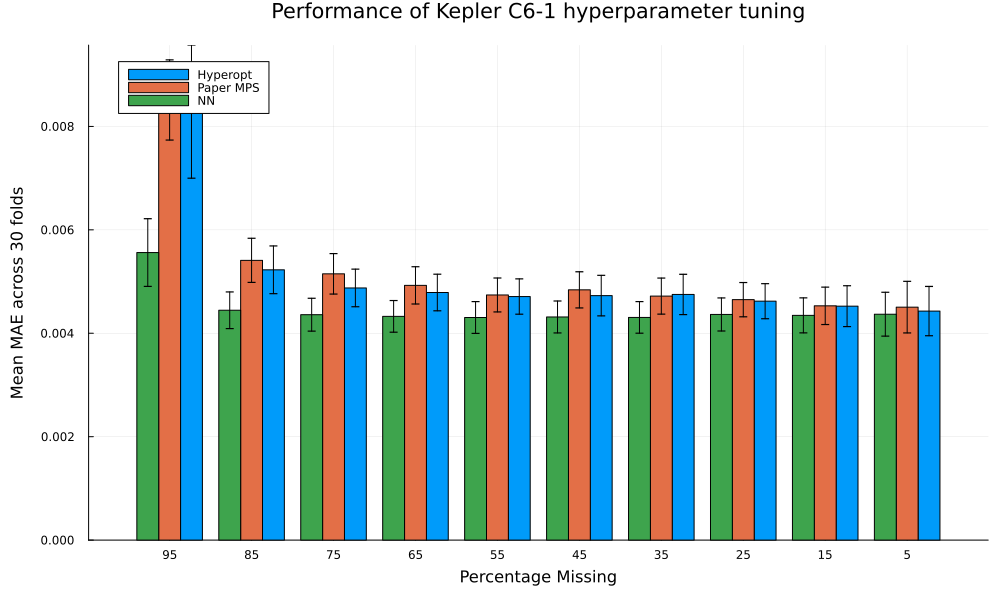

In [42]:
groupedbar(
    pms, 
    [mmae_r250_c6_1 mmaes_by_pm_c6_mps_paper[1,:] mmaes_by_pm_c6_nn_paper[1,:] ]; 
    yerr =1.96 .* [std_r250_c6_1 stds_by_pm_c6_mps_paper[1,:] stds_by_pm_c6_nn_paper[1,:] ] ./sqrt(30) , 
    xticks = pms, 
    labels=["Hyperopt" "Paper MPS" "NN" ], 
    legend=:topleft,
    size=(1000,600),
    bottom_margin=5mm, left_margin=5mm, top_margin=5mm
)
xflip!(true)
xlabel!("Percentage Missing")
ylabel!("Mean MAE across 30 folds")
title!("Performance of Kepler C6-1 hyperparameter tuning")
# savefig("KeplerC6-1.png")

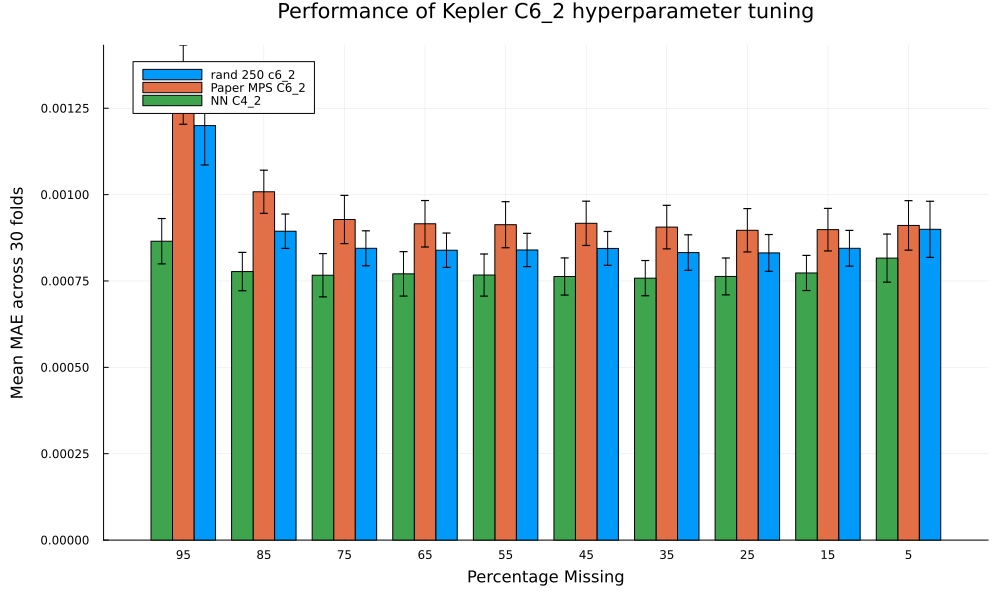

In [43]:
groupedbar(
    pms, 
    [mmae_r250_c6_2 mmaes_by_pm_c6_mps_paper[2,:] mmaes_by_pm_c6_nn_paper[2,:] ]; 
    yerr =1.96 .* [std_r250_c6_2 stds_by_pm_c6_mps_paper[2,:] stds_by_pm_c6_nn_paper[2,:] ] ./sqrt(30) , 
    xticks = pms, 
    labels=["rand 250 c6_2" "Paper MPS C6_2" "NN C4_2" ], 
    legend=:topleft,
    size=(1000,600),
    bottom_margin=5mm, left_margin=5mm, top_margin=5mm
)
xflip!(true)
xlabel!("Percentage Missing")
ylabel!("Mean MAE across 30 folds")
title!("Performance of Kepler C6_2 hyperparameter tuning")
# savefig("Kepler2.png")

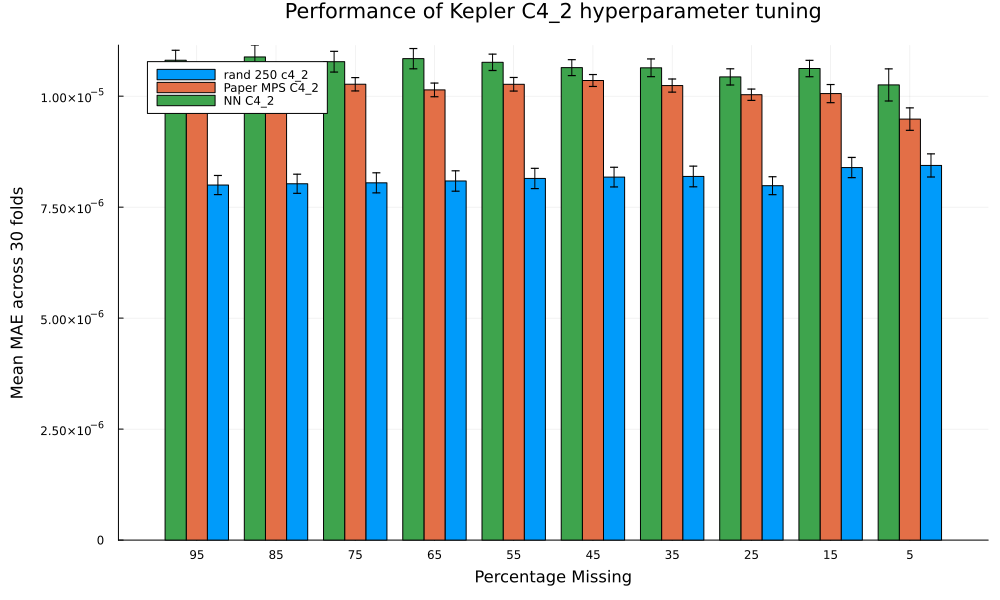

In [45]:
groupedbar(
    pms, 
    [mmae_r250_c4_2 mmaes_by_pm_c4_mps_paper[2,:] mmaes_by_pm_c4_nn_paper[2,:] ]; 
    yerr =1.96 .* [std_r250_c4_2 stds_by_pm_c4_mps_paper[2,:] stds_by_pm_c4_nn_paper[2,:] ] ./sqrt(30) , 
    xticks = pms, 
    labels=["rand 250 c4_2" "Paper MPS C4_2" "NN C4_2" ], 
    legend=:topleft,
    size=(1000,600),
    bottom_margin=5mm, left_margin=5mm, top_margin=5mm
)
xflip!(true)
xlabel!("Percentage Missing")
ylabel!("Mean MAE across 30 folds")
title!("Performance of Kepler C4_2 hyperparameter tuning")
# savefig("Kepler2.png")

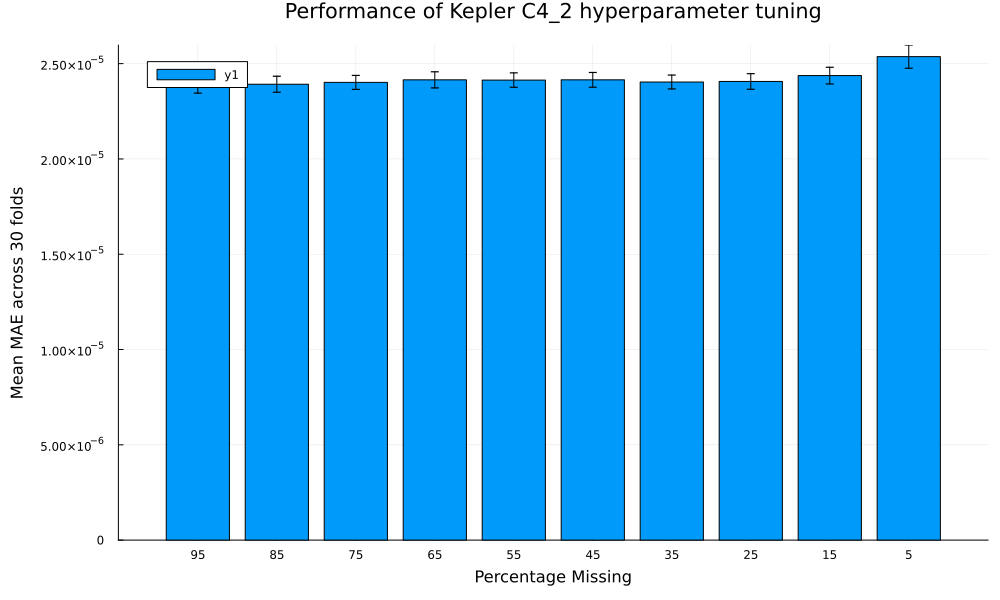

In [47]:
bar(
    pms, 
    mmae_r250_c4_1  ; 
    yerr =1.96 .* std_r250_c4_1  ./sqrt(30) , 
    xticks = pms, 
    # labels=["rand 250 c4_2" "Paper MPS C4_2" "NN C4_2" ], 
    legend=:topleft,
    size=(1000,600),
    bottom_margin=5mm, left_margin=5mm, top_margin=5mm
)
xflip!(true)
xlabel!("Percentage Missing")
ylabel!("Mean MAE across 30 folds")
title!("Performance of Kepler C4_2 hyperparameter tuning")
# savefig("Kepler2.png")

In [48]:
ds, chis, losses, anns = get_hm_vals(res_r250_c4)
hm =heatmap(ds, chis, losses,
    size=(1100,600),
    colorbar_title="Mean MAE",
    bottom_margin=5mm, 
    left_margin=5mm, 
    right_margin=5mm,
    top_margin=5mm
)
annotate!(anns...)
xlabel!(L"$\chi_{\rm{max}}$")
ylabel!("ds")
title!("Best Performing parameters on each Kepler C4-1 Fold")
plot(hm)
savefig("KeplerC4-1_heatmap.png")

"/home/noodles/.julia/dev/MPSTime.jl/Folds/KeplerC4-1_heatmap.png"

In [57]:
ds, chis, losses, anns = get_hm_vals(res_r250_c4_2)
hm =heatmap(ds, chis, losses,
    size=(1100,600),
    colorbar_title="Mean MAE",
    bottom_margin=5mm, 
    left_margin=5mm, 
    right_margin=5mm,
    top_margin=5mm
)
annotate!(anns...)
xlabel!(L"$\chi_{\rm{max}}$")
ylabel!("ds")
title!("Best Performing parameters on each Kepler C4-2 Fold")
plot(hm)
savefig("KEPC4-2_heatmap.png")

"/home/noodles/.julia/dev/MPSTime.jl/Folds/Josh/Kepler/KEPC4-2_heatmap.png"

In [22]:
res_r250_c4_2[1]

Dict{String, Any} with 13 entries:
  "eval_windows"   => [[39, 40, 41, 42, 43], [8, 9, 10, 11, 12], [83, 84, 85, 8…
  "cache"          => Dict{Tuple{Int64, Int64, Float64}, Float64}()
  "time"           => 1548.87
  "tuning_pms"     => [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.…
  "objective"      => "ImputationLoss()"
  "train_inds"     => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  32, 33, 34, 35, 36, 37…
  "optimiser"      => "MPSRandomSearch(:LatinHypercube)"
  "loss"           => [6.51425e-6, 1.32862e-5, 1.02406e-5, 1.08008e-5, 4.76438e…
  "eval_pms"       => nothing
  "opts"           => MPSOptions(-5, 10, 21, 0.00233633, 5, :Legendre_No_Norm, …
  "fold"           => 1
  "test_inds"      => [42, 43]
  "tuning_windows" => nothing

In [51]:
ds, chis, losses, anns = get_hm_vals(res_r250_c6)
hm =heatmap(ds, chis, losses,
    size=(1100,600),
    colorbar_title="Mean MAE",
    bottom_margin=5mm, 
    left_margin=5mm, 
    right_margin=5mm,
    top_margin=5mm
)
annotate!(anns...)
xlabel!(L"$\chi_{\rm{max}}$")
ylabel!("ds")
title!("Best Performing parameters on each Kepler C6-1 Fold")
plot(hm)
savefig("KepC6-1_heatmap.png")

"/home/noodles/.julia/dev/MPSTime.jl/Folds/KepC6-1_heatmap.png"